**IMPORTAR LIBRERIAS**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**CARGAR DATOS**

In [2]:
historico_palma = pd.read_excel("/content/drive/MyDrive/Escenarios/datos/historico-palma.xlsx")
historico_arroz = pd.read_excel("/content/drive/MyDrive/Escenarios/datos/historico-arroz.xlsx")
historico_cacao = pd.read_excel("/content/drive/MyDrive/Escenarios/datos/historico-cacao.xlsx")
historico_bovino = pd.read_excel("/content/drive/MyDrive/Escenarios/datos/historico-bovino-animal.xlsx")
historico_porcino = pd.read_excel("/content/drive/MyDrive/Escenarios/datos/historico-porcino.xlsx")
proporcion = pd.read_excel("/content/drive/MyDrive/Escenarios/datos/proporcion.xlsx")

**Generar historico a nivel de cuenca desde los datos historicos municipales**

In [3]:
# Calcular hectáreas de cada cultivo en cada cuenca
def calcular_hectareas(historico, cultivo):
    df = historico.melt(id_vars=['Municipio'], var_name='Año', value_name='Hectáreas')
    df['Cultivo'] = cultivo
    df = df.merge(proporcion, left_on='Municipio', right_on='Municipio')
    df['Año'] = df['Año'].astype(int)
    for cuenca in proporcion.columns[1:]:
        df[cuenca] = df['Hectáreas'] * df[cuenca]
    df.drop(['Hectáreas', 'Municipio'], axis=1, inplace=True)
    df = df.melt(id_vars=['Año', 'Cultivo'], var_name='Cuenca', value_name='Hectáreas')
    return df

resultado_palma = calcular_hectareas(historico_palma, 'Palma')
resultado_arroz = calcular_hectareas(historico_arroz, 'Arroz')
resultado_cacao = calcular_hectareas(historico_cacao, 'Cacao')
resultado_bovino = calcular_hectareas(historico_bovino, 'Bovino')
resultado_porcino = calcular_hectareas(historico_porcino, 'Porcino')

# Concatenar datos
resultado_agrupado = pd.concat([resultado_palma, resultado_arroz, resultado_cacao, resultado_bovino, resultado_porcino], ignore_index=True)
resultado_agrupado = resultado_agrupado.groupby(['Año', 'Cuenca', 'Cultivo']).sum().reset_index()
# Guardar resultados
resultado_agrupado.to_excel("/content/drive/MyDrive/Escenarios/resultados/historico-cuenca.xlsx", index = False)
resultado_agrupado.head()

,Año,Cuenca,Cultivo,Hectáreas
0,2007,Casanare,Arroz,1086.074052
1,2007,Casanare,Bovino,309111.642758
2,2007,Casanare,Cacao,6993.135725
3,2007,Casanare,Palma,0.000000
4,2007,Casanare,Porcino,0.000000


**Crear los modelos de regresión lineal simple para cada cultivo segun cuenca**

In [4]:
df = pd.read_excel("/content/drive/MyDrive/Escenarios/resultados/historico-cuenca.xlsx")

# Initialize an empty DataFrame to store the results
result_df = pd.DataFrame(columns=['Cuenca', 'Cultivo', 'Ecuación de la Recta', 'R^2'])

# Group the data by 'Cuenca' and 'Cultivo'
grouped = df.groupby(['Cuenca', 'Cultivo'])

# Loop through each group to fit a simple linear regression model
for (cuenca, cultivo), group_data in grouped:
    X = group_data['Año'].values.reshape(-1, 1)
    y = group_data['Hectáreas'].values

    # Fit the model
    model = LinearRegression()
    model.fit(X, y)

    # Get the slope and intercept of the line
    slope = model.coef_[0]
    intercept = model.intercept_

    # Get the R^2 value
    r_squared = model.score(X, y)

    # Create the equation of the line
    equation = f'y = {slope:.4f} * x + {intercept:.4f}'

    # Append the results to the DataFrame
    result_df = result_df.append({
        'Cuenca': cuenca,
        'Cultivo': cultivo,
        'Ecuación de la Recta': equation,
        'R^2': r_squared
    }, ignore_index=True)

result_df.to_excel("/content/drive/MyDrive/Escenarios/resultados/modelos-regresion-cultivo.xlsx", index = False)
result_df.head()

,Cuenca,Cultivo,Ecuación de la Recta,R^2
0,Casanare,Arroz,y = 1482.7601 * x + -2974065.7714,0.891787
1,Casanare,Bovino,y = 81053.8395 * x + -162543746.9808,0.853790
2,Casanare,Cacao,y = 354.5253 * x + -704296.6807,0.913401
3,Casanare,Palma,y = -0.8147 * x + 1681.4223,0.004108
4,Casanare,Porcino,y = 3394.0233 * x + -6819731.9107,0.700900


**Generación de predicción 2040**

In [5]:
# Ajuste de Modelos de Regresión Lineal
resultados_predicciones = pd.DataFrame(columns=['Cuenca', 'Cultivo', 'Año', 'Predicción', 'IC_inf', 'IC_sup', 'IP_inf', 'IP_sup'])
cuencas_unicas = resultado_agrupado['Cuenca'].unique()
cultivos_unicos = resultado_agrupado['Cultivo'].unique()
for cuenca in cuencas_unicas:
    for cultivo in cultivos_unicos:
        datos_cuenca_cultivo = resultado_agrupado[(resultado_agrupado['Cuenca'] == cuenca) & (resultado_agrupado['Cultivo'] == cultivo)]
        modelo = ols('Hectáreas ~ Año', data=datos_cuenca_cultivo).fit()

        # Para la línea de tendencia, IC e IP desde el 2007 hasta el 2040
        predicciones_df = pd.DataFrame({'Año': np.arange(2007, 2041)})
        predicciones_df['Cuenca'] = cuenca
        predicciones_df['Cultivo'] = cultivo
        predicciones = modelo.get_prediction(predicciones_df[['Año']])
        predicciones_summary = predicciones.summary_frame(alpha=0.05) # Intervalos al 95%
        predicciones_df['Predicción'] = predicciones_summary['mean']
        predicciones_df['IC_inf'] = predicciones_summary['mean_ci_lower']
        predicciones_df['IC_sup'] = predicciones_summary['mean_ci_upper']
        predicciones_df['IP_inf'] = predicciones_summary['obs_ci_lower']
        predicciones_df['IP_sup'] = predicciones_summary['obs_ci_upper']

        # Solo aplicar la predicción aleatoria en el rango de 2023 a 2040
        predicciones_df['Predicción_aleatoria'] = predicciones_df.apply(lambda row: np.random.uniform(row['IP_inf'], row['IP_sup']) if row['Año'] >= 2023 else np.nan, axis=1)

        resultados_predicciones = resultados_predicciones.append(predicciones_df, ignore_index=True)

# Corregir el tipo de datos
resultados_predicciones['Año'] = resultados_predicciones['Año'].astype(int)

# Generar predicciones aleatorias dentro de los intervalos de predicción
np.random.seed(42)
resultados_predicciones['Predicción_aleatoria'] = resultados_predicciones.apply(lambda row: np.random.uniform(row['IP_inf'], row['IP_sup']), axis=1)
resultados_predicciones.to_excel("/content/drive/MyDrive/Escenarios/resultados/prediccion-2007-2040.xlsx", index = False)
resultados_predicciones.head()

,Cuenca,Cultivo,Año,Predicción,IC_inf,IC_sup,IP_inf,IP_sup,Predicción_aleatoria
0,Casanare,Arroz,2007,1833.793538,-772.666242,4440.253318,-4215.830928,7883.418004,315.823205
1,Casanare,Arroz,2008,3316.553660,957.232629,5675.874692,-2630.775095,9263.882416,8677.645970
2,Casanare,Arroz,2009,4799.313782,2674.583581,6924.043983,-1058.911377,10657.538942,7517.459276
3,Casanare,Arroz,2010,6282.073904,4374.750997,8189.396812,499.150399,12064.997410,7423.142839
4,Casanare,Arroz,2011,7764.834026,6051.182232,9478.485821,2042.865303,13486.802749,3828.332865


**Visualización**

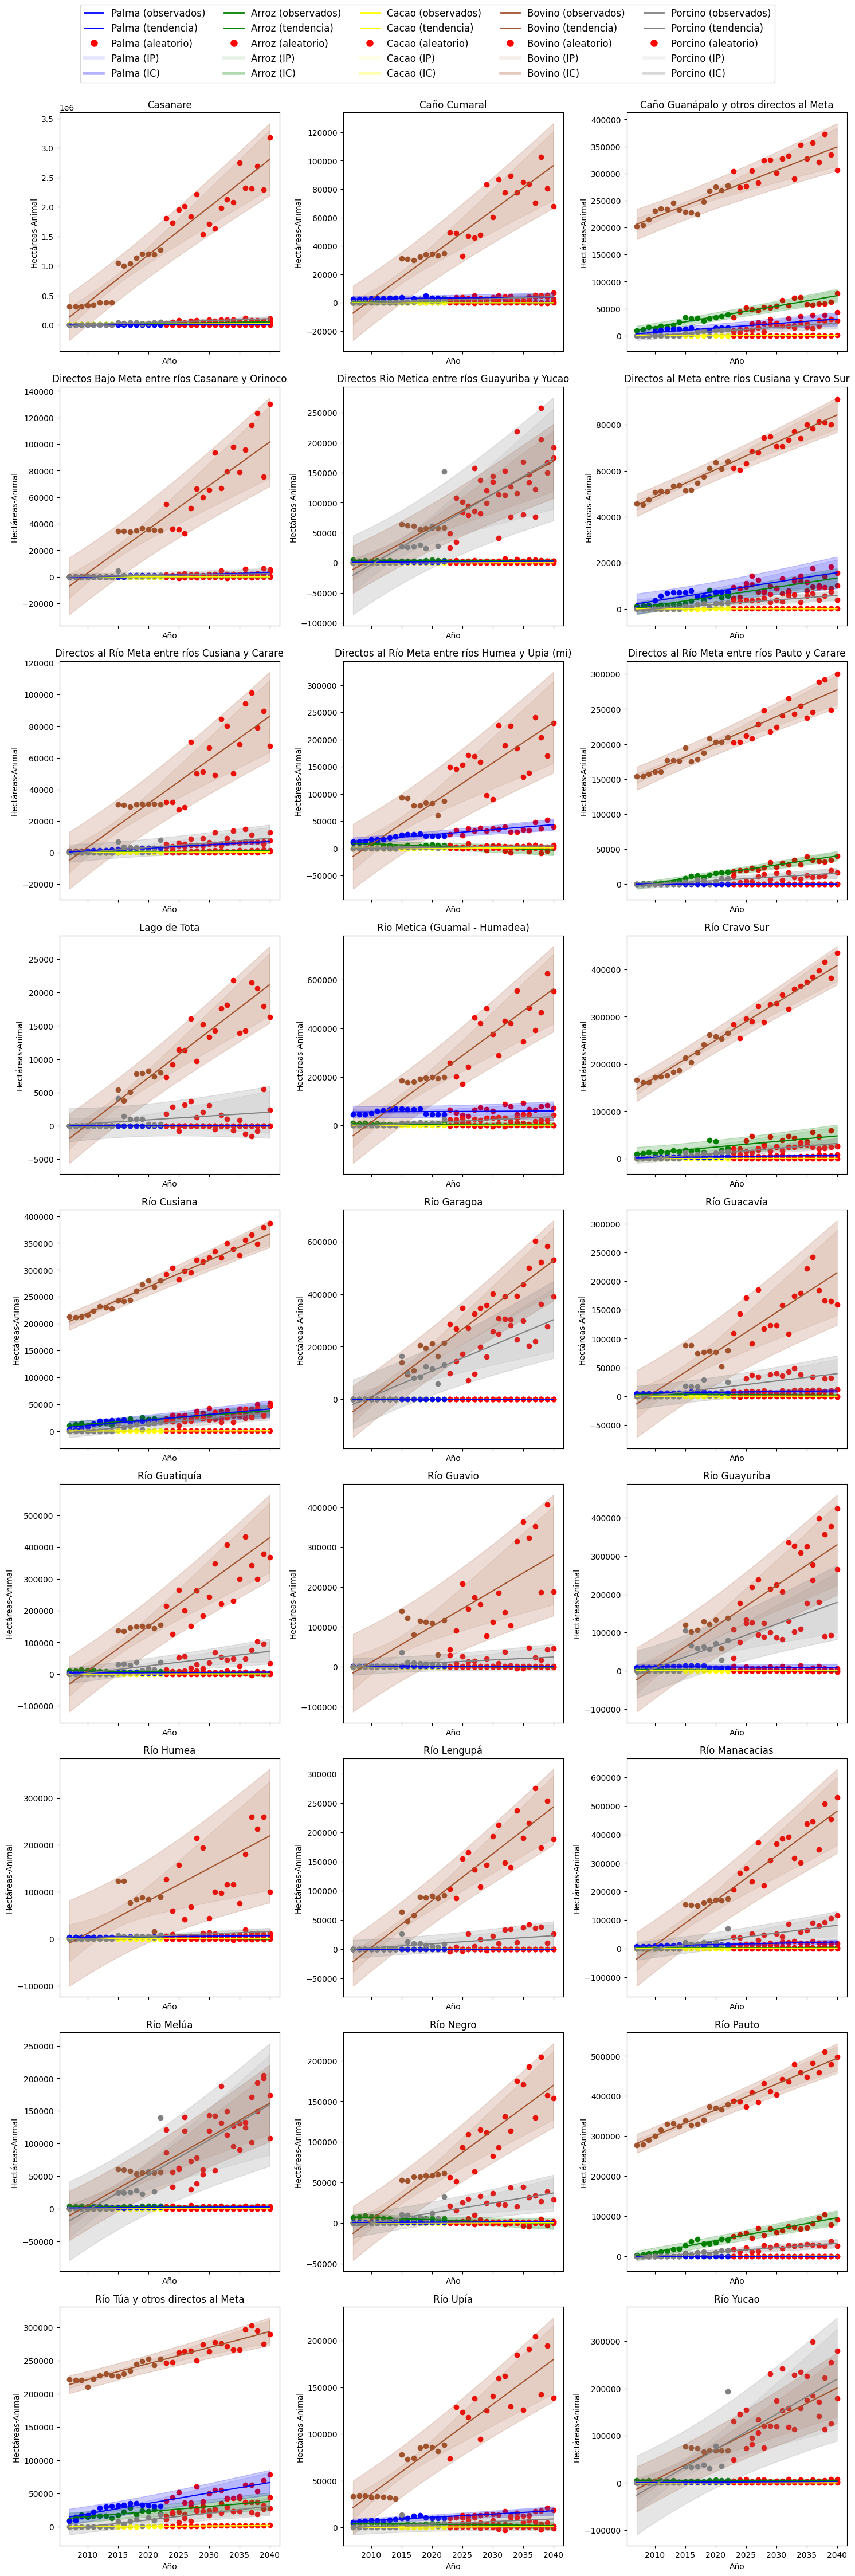

In [6]:
# Visualizar resultados
colores = {'Palma': 'blue', 'Arroz': 'green', 'Cacao': 'yellow', 'Bovino': 'sienna', 'Porcino': 'gray'}

fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(15, 45), sharex=True)

lineas = []
etiquetas = []
for cultivo, color in colores.items():
    lineas.extend([plt.Line2D([0], [0], color=color, lw=2),
                   plt.Line2D([0], [0], color=color, lw=2, linestyle='-'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10),
                   plt.Line2D([0], [0], color=color, lw=4, alpha=0.1),
                   plt.Line2D([0], [0], color=color, lw=4, alpha=0.3)])
    etiquetas.extend([f'{cultivo} (observados)',
                      f'{cultivo} (tendencia)',
                      f'{cultivo} (aleatorio)',
                      f'{cultivo} (IP)',
                      f'{cultivo} (IC)'])

for i, cuenca in enumerate(cuencas_unicas):
    ax = axes[i // 3, i % 3]
    datos_cuenca = resultados_predicciones[resultados_predicciones['Cuenca'] == cuenca]
    for cultivo in cultivos_unicos:
        datos_cultivo = datos_cuenca[datos_cuenca['Cultivo'] == cultivo]
        datos_historicos = resultado_agrupado[(resultado_agrupado['Cuenca'] == cuenca) & (resultado_agrupado['Cultivo'] == cultivo)]

        # Visualizar solo los datos aleatorios predichos desde el 2023 hasta el 2040
        datos_cultivo_futuro = datos_cultivo[datos_cultivo['Año'] >= 2023]

        ax.scatter(datos_historicos['Año'], datos_historicos['Hectáreas'], color=colores[cultivo])
        ax.plot(datos_cultivo['Año'], datos_cultivo['Predicción'], color=colores[cultivo], linestyle='-')
        ax.scatter(datos_cultivo_futuro['Año'], datos_cultivo_futuro['Predicción_aleatoria'], color='red')
        ax.fill_between(datos_cultivo['Año'], datos_cultivo['IP_inf'], datos_cultivo['IP_sup'], color=colores[cultivo], alpha=0.2) # Intervalo de Predicción
        ax.fill_between(datos_cultivo['Año'], datos_cultivo['IC_inf'], datos_cultivo['IC_sup'], color=colores[cultivo], alpha=0.1) # Intervalo de Confianza

    ax.set_title(cuenca)
    ax.set_xlabel('Año')
    ax.set_ylabel('Hectáreas-Animal')

fig.legend(lineas, etiquetas, loc='upper center', ncol=5, fontsize='large')
plt.tight_layout(rect=[0, 0, 1, 0.965])
plt.show()

**Excel con los resultados de predicción tendencial 2023 - 2040**

In [7]:
prediccion_2023_2024 = resultados_predicciones.query('2023 <= Año <= 2040')
prediccion_2023_2024.rename(columns={'Predicción': 'Predicción-Tendencial'}, inplace=True)
prediccion_2023_2024 = prediccion_2023_2024[['Cuenca', 'Cultivo', 'Año', 'Predicción-Tendencial', 'IC_inf', 'IC_sup']]
prediccion_2023_2024[['Predicción-Tendencial', 'IC_inf', 'IC_sup']] = prediccion_2023_2024[['Predicción-Tendencial', 'IC_inf', 'IC_sup']].round().astype(int)
prediccion_2023_2024.to_excel("/content/drive/MyDrive/Escenarios/resultados/prediccion-2023-2040.xlsx", index = False)
prediccion_2023_2024.head()

,Cuenca,Cultivo,Año,Predicción-Tendencial,IC_inf,IC_sup
16,Casanare,Arroz,2023,25558,22695,28421
17,Casanare,Arroz,2024,27041,23914,30167
18,Casanare,Arroz,2025,28523,25128,31919
19,Casanare,Arroz,2026,30006,26338,33674
20,Casanare,Arroz,2027,31489,27544,35434
